# PyTorch workflow fundamentals

PyTorch is an open source machine learning and deep learning framework originally developed by META. I have chosen to learn PyTorch over tensorflow mainly as it seems more widely used and more user friendly. PyTorch offers GPU acceleration that vastly increases model training time (we will see this later on) and makes producing NN models much easier.

First we will start with importing pytorch which can be done with the below code (it is often useful to sepertly import different modules like torch.nn, optim and functional seperately).

In [27]:
import torch
torch.__version__

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

Machine learning is a game of two parts:
* Turning data into numbers (a represenation)
* Pick or build  a model to learn the representation

To show an example we will create some linear data with known parameters and make a model to estimate these paramaters.

In [38]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1).to(device)
y = weight * X + bias
y = y.to(device)
X[:10], y[:10]
print("")

<bold> NOTE </bold> In the above code the .unsqueeze() turns the array from a 1D array of size (50) to a 2D array of size (50,1)  which is the dimensions used for implemenation of most modes, but this will be covered more later.

First  we will split our data into a training set and a testing set, below we will just split it but normally you would want randomly split the data (don't think this is always true for sequential data) and then create a function to plot our prediction data and training data.

In [45]:
import matplotlib.pyplot as plt
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split].to(device), y[:train_split].to(device)
X_test, y_test = X[train_split:].to(device), y[train_split:].to(device)


def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(8, 6))

  # Plot training data in blue
  plt.scatter(train_data.cpu(), train_labels.cpu(), c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data.cpu(), test_labels.cpu(), c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data.cpu(), predictions.cpu(), c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

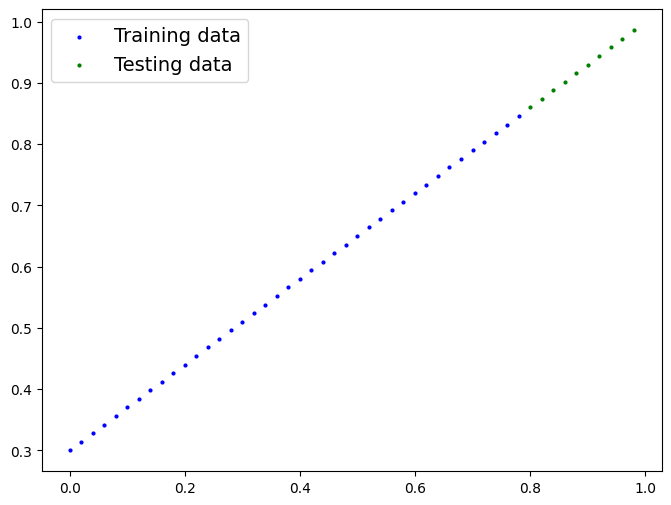

In [17]:
plot_predictions()

## Building a model

Now that we have our data, we will build a model using the blue dots (training data) to predict our green dots (testing data), here we will jump straight into building our model and will explain it later.

In [25]:
# Creata a linear regression model
class LinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = torch.nn.Parameter(torch.randn(1,
                                                      dtype = torch.float)
                                                      , requires_grad = True)
        self.bias = torch.nn.Parameter(torch.randn(1, 
                                            dtype=torch.float), 
                                requires_grad=True)
        
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

torch.nn contains all the building blocks for computational graphs and contains nn.Paramter and nn.Module which are used to build out classes, and torch.optim contains various optimisation algorithms for optimisation a given loss funciton. The requires_grad = True ensures that all operations on a tensor are tracked so they can compute gradients during back proppagation, requires_grad = False can be used for static layers or paramaters in a model.

<bold> Checking contents of a pytorch model </bold>

We will now create a model instance and check its parameters using .paramaters().

In [40]:
# Set manual seed 
torch.manual_seed(42)

# Create a model
model_0 = LinearRegressionModel().to(device)

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

# List named parameters 
model_0.state_dict()



cpu


Here we see that weight and bias are initatied with random values ( which are the same each time since there is a set seed right now) and our aim is to find the true values.

We can also make predictions using torch.inference_mode() to see how closely our models predicts y to the true values.

In [43]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)

print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], device='cuda:0')


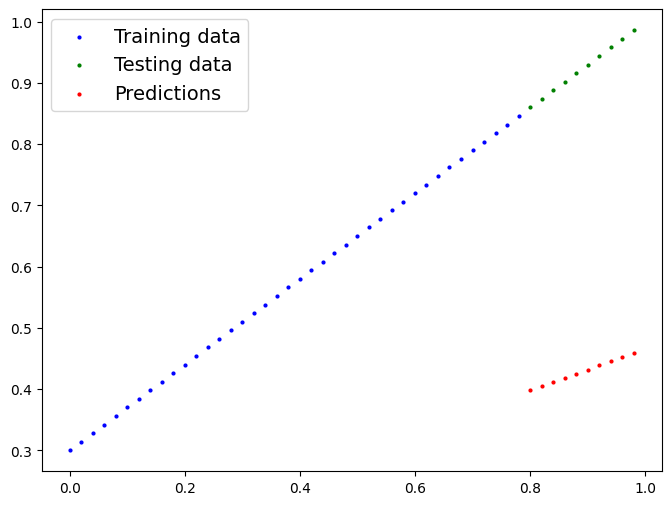

In [46]:
plot_predictions(predictions=y_preds)

As we see the randomly initalised model has an awful prediction of the data.

## Training the model

To train our model we need to chosen 2 things:

* A loss function
* An optimiser

The chose of loss function and optimiser depends both on the type of problem and what metric is important for use and imformation of the different loss functions can be found [here](https://pytorch.org/docs/stable/nn.functional.html) and optimisers can be fouund [here](https://pytorch.org/docs/stable/optim.html).

For our model we will use MSR (l1loss) and SGD.


In [55]:
# Create the loss funciton
loss_fn = torch.nn.L1Loss() 

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.001)

### Creating an optimisation loop

Defining  a training loop in pytorch follows the following standard structure:

* Forward pass
* Calculate the loss
* Zero gradients
* Perform back propagation
* Update the optimiser ( gradient descent)

In [59]:


torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(1, epochs +1 ):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.cpu().detach().numpy())
            test_loss_values.append(test_loss.cpu().detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")


Epoch: 10 | MAE Train Loss: 0.00028008074150420725 | MAE Test Loss: 0.0013304412132129073 
Epoch: 20 | MAE Train Loss: 0.00028008074150420725 | MAE Test Loss: 0.0013304412132129073 
Epoch: 30 | MAE Train Loss: 0.00028008074150420725 | MAE Test Loss: 0.0013304412132129073 
Epoch: 40 | MAE Train Loss: 0.00028008074150420725 | MAE Test Loss: 0.0013304412132129073 
Epoch: 50 | MAE Train Loss: 0.00028008074150420725 | MAE Test Loss: 0.0013304412132129073 
Epoch: 60 | MAE Train Loss: 0.00028008074150420725 | MAE Test Loss: 0.0013304412132129073 
Epoch: 70 | MAE Train Loss: 0.00028008074150420725 | MAE Test Loss: 0.0013304412132129073 
Epoch: 80 | MAE Train Loss: 0.00028008074150420725 | MAE Test Loss: 0.0013304412132129073 
Epoch: 90 | MAE Train Loss: 0.00028008074150420725 | MAE Test Loss: 0.0013304412132129073 
Epoch: 100 | MAE Train Loss: 0.00028008074150420725 | MAE Test Loss: 0.0013304412132129073 


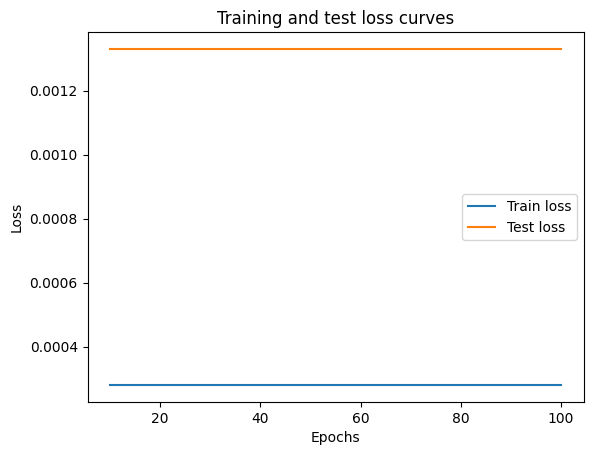

In [60]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()


As we see our model almost instantly optimises (i assume due to training on gpu) due to the simplicity of the model.

## Making predictions with a trained pytorch model

Once you have trained a model, you will likely want to make predictions with it, and we have already seen a glimpse of this in the training/testing loop above.

There are 3 things to remember when making predictions with a pytorch model:

* Set the model in evaluation mode ( model.eval() )
* Make the predictions using the inference mode context manager ( torch.inference.mode() )
* All predictions should be make with the objects and data on the same device.

The first 2  make sure all calculations used during training do not occur, allowing faster computation and the third ensures no cross device errors.

In [62]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8588],
        [0.8727],
        [0.8867],
        [0.9007],
        [0.9147],
        [0.9287],
        [0.9426],
        [0.9566],
        [0.9706],
        [0.9846]], device='cuda:0')

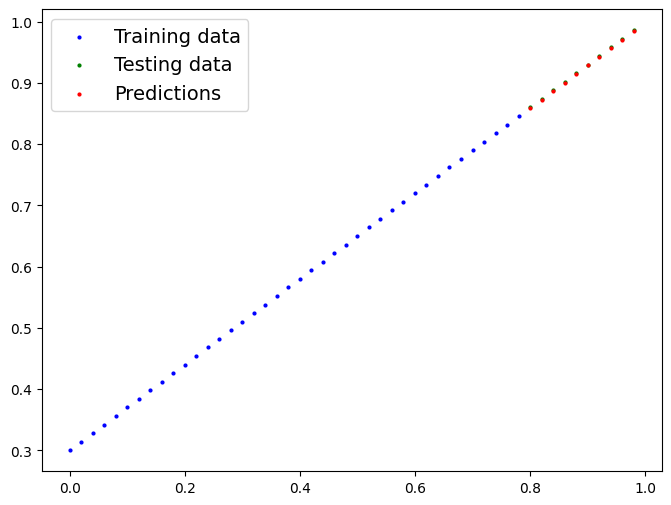

In [63]:
plot_predictions(predictions=y_preds)

As we see our model almost completely accuratly predicts the testing data.

## Saving and loading a PyTorch model

After you have train a Pytorch model, it is often useful to save and export the model elsewhere, like we could train it on an external server (like google colab) and then export it externally to use.

For saving and loading models in pytorch, there are 3 main methods 
* torch.save
* torch.load
* torch.nn.Module.load_state_dict

### Saving a model

The [recommend way](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) of saving a model for inference is by saving and loading a model's state_dict and we can do it in a few steps
* We'll create a directory for saving models to be called models using pythons pathlib module
* We'll create a file path to save the model to 
* We'll call torch.save(obj, f)

As shown below

In [67]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_0.pth


### Loading a saved Pytorch model's state_dict

Since we've now got a saved model state_dict() saved within our directory, we can load it using torch.nn.Module.load_state_dict(torch.load(f)) The reason we load it into a load state is so that we create  a new instance of our module, which is a subclass of nn.Module.

Why not just save the entire model?

Saving the entire model is rather my intuitive, however the approeach of serialised data can cause the code to break in various ways when used in other projects or refactors.

An example of loading the model is shown below (the weights_only = True is just so i didnt get a random error):

In [70]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH,weights_only=True ))


<All keys matched successfully>

We can then use the loaded_model_0 the same way as before.

## Exercises

We will now put it all together by trying to tackle the exercises at the bottom of [learnpytorch.io](https://www.learnpytorch.io/01_pytorch_workflow/#5-saving-and-loading-a-pytorch-mode).

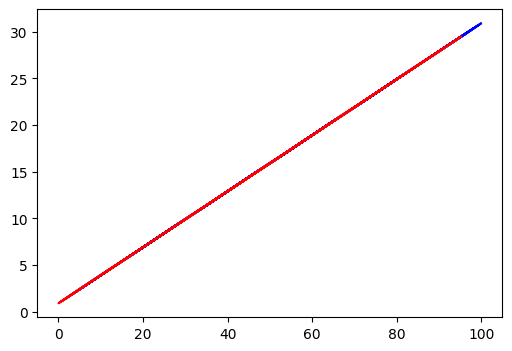

In [94]:
from sklearn.model_selection import train_test_split

# Set the weight
weight_ex = 0.3
# Set the bias
bias_ex = 0.9

# Create 150 data points in a (150, 1) tensor on the GPU
X_ex = torch.linspace(0, 100, 150).to(device).unsqueeze(dim = 1)
# Create y's according to the relationship
y = weight_ex * X_ex + bias_ex


X_ex_train, X_ex_test, y_ex_train, y_ex_test = train_test_split(X_ex, y)

def plot_data(y_pred = None,
              X_train = X_ex_train, 
              y_train = y_ex_train,
              X_test = X_ex_test,
              y_test = y_ex_test
              ):




    fig = plt.figure(figsize = (6,4))
    
    plt.plot(X_train.cpu(), y_train.cpu(), c = "b" )
    plt.plot(X_test.cpu(), y_test.cpu(), c ="r")
    if y_pred != None:
        plt.plot(X_test.cpu(), y_pred.cpu() , c = "o")


plot_data()

In [143]:
class LinearRegressionModelExercise(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.weight = torch.nn.Parameter(torch.rand(1, dtype = torch.float)
                                 , requires_grad = True)
        self.bias = torch.nn.Parameter(torch.rand(1, dtype = torch.float)
                                 , requires_grad = True)
    def forward(self, X : torch.Tensor) -> torch.Tensor:
        return self.weight * X + self.bias


model_exerise = LinearRegressionModelExercise().to(device)

optimiser_exercise = torch.optim.Adam(params= model_exerise.parameters(), lr = 0.01)
loss_exercise = torch.nn.L1Loss()

EPOCHES_E = 3000

for _ in range(1, EPOCHES_E + 1):
    predictions = model_exerise.forward(X_ex_train)

    loss = loss_exercise(predictions, y_ex_train)

    optimiser_exercise.zero_grad()

    loss.backward()
    
    optimiser_exercise.step()

print(model_exerise.state_dict())




OrderedDict({'weight': tensor([0.3005], device='cuda:0'), 'bias': tensor([0.9008], device='cuda:0')})
